# Simulations with effective noises

## Introduction
In the tutorial _Simulating sequences with errors and noises_, we introduced effective noise channels and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

The effective noise models implemented here are based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equations and want to know deeper, please check this ressource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

Recall the Lindblad equation:

$$
\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)
$$ 

The operators $L_k$ are often called *Collapse operators*. Basically, an effective noise channel can be fully described by a set of collapse operators which are linked with each other by a the following completeness relation:  $\sum_k L_k L_k^\dagger = \mathbb{I}$.

So varying $L_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* The dephasing channel
* The depolarizing channel


In [26]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import SimulationResults
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device

## Effective noise channels

### The Dephasing channel


_Dephasing_ is the phenomenon associated with the decay of the coherence terms (off-diagonals) in the density matrix without loss of energy.

The dephasing noise can be thought of as arising from random z-rotations across the state, with a certain probability $p$. This can be modelled as the action of the following operators:

$$
L_0 = \sqrt{1-\frac{p}{2}} \,\, \mathbb{I} \\
L_1 = \sqrt{\frac{p}{2}} \,\, \sigma_z
$$

### The Depolarizing channel

We can describe this channel as one where with probability $1-p$ the qubit remains intact, while with probability $p$ an “error” occurs, in the form of an operator from the set $\{\sigma_x, \sigma_y, \sigma_z \}$.

That is, if an error occurs, then $\ket{\psi} $ evolves during the time step to an ensemble of the four states equally likely: 

$$ 
\ket{\psi} \to \{ \sigma_x \ket{\psi}, \sigma_y \ket{\psi}, \sigma_z \ket{\psi}, \ket{\psi} \}.
$$

Some papers choose not to include the idle state amid the error states. It doesn't change the effects of the noise channel. We will stick to the model of the depolarizing channel presented in [Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview) book.

The underlying collapse operators are then:

$$
L_0 = \sqrt{1-\frac{3}{4}p} \,\, \mathbb{I}, \\
L_1 = \sqrt{\frac{p}{4}} \sigma_x, \\
L_2 = \sqrt{\frac{p}{4}}\sigma_z, \\
L_3 = \sqrt{\frac{p}{4}} \sigma_y
$$


That is, if an error occurs, then $\ket{\psi} $ evolves to an ensemble of the four states equally likely: $\sigma_x\psi $, $\sigma_y\psi $, $\sigma_z\psi $, $\psi $.

## Single atom noisy simulations

In this section we will study the impact of effective noise channels on a single qubit under a resonant pulse. We prepare a single atom:

In [27]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

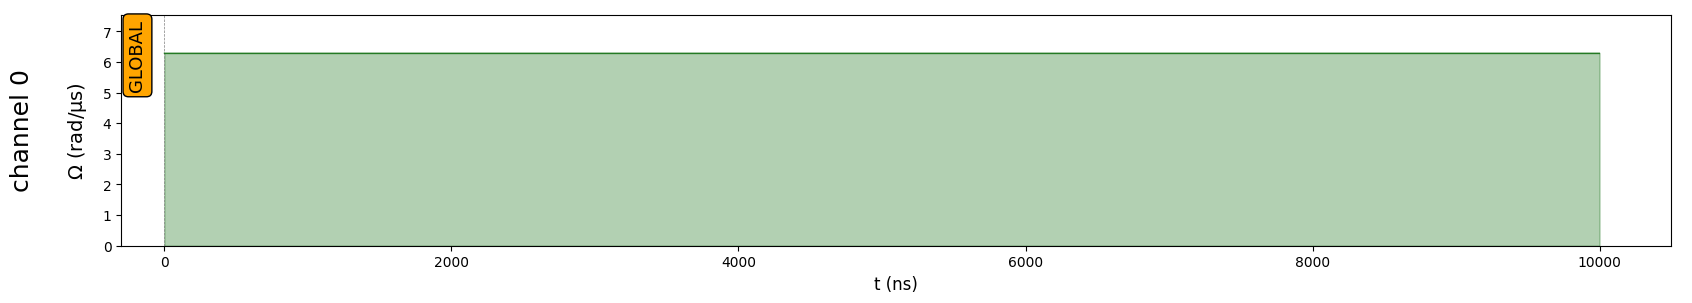

In [28]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

We now run the "clean" simulation

In [29]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the ground state population using its projector and then the `plot()` method from the `Results` object:

Text(0, 0.5, 'Ground state population')

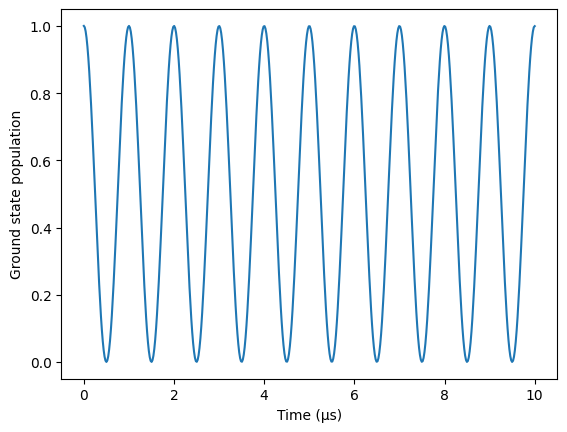

In [30]:
obs = (
    clean_simu.initial_state.proj()
)  # Make projector from initial state of the Simulation object (uses QuTiP)
clean_res.plot(obs)  # Plot the expectation value of the observable
plt.ylabel("Ground state population")

The are two ways to define the dephasing and depolarizing channels in pulser. The first way is to create a `SimConfig` object, specifying you want the dephasing noise and choosing the dephasing probability `dephasing_prob`:

In [31]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


Likewise we can create a SimConfig object for the depolarizing noise. Notice how we reset the configuration using the `reset_config()` method:

In [32]:
clean_simu.reset_config()
config_depolarizing = SimConfig(noise="depolarizing", depolarizing_prob=0.1)
clean_simu.set_config(config_depolarizing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           depolarizing
Depolarizing probability: 0.1


The second way, which is more general, allows the user to define any Kraus channel to describe effective noise.

In [33]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[
        1 - 0.05,
        0.05,
    ],  # Need to add up to 1 to be a valid probability distribution
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


This is more explicit than the first method since we see the operators corresponding to the effective noise channel. Using the `eff_noise` noise type we can implement the *dephasing channel*, in which case the operators are: $\mathbb{I}$ and $\sigma_z$, which we define in the `Effective noise operators` field.

This allows you to design other effective noise channels such as `amplitude damping` or `phase damping` by inputting the defining noise operators.

Let us now simulate the entire sequence with our two effective noise channels. We define some useful functions for our simulations:

In [34]:
def get_population(rho, psi_0):
    """
    Expectation value of the input density matrix over a given direction psi_0
    """
    return np.real(psi_0.dag() * rho * psi_0)


def get_population_evolution(result: SimulationResults, state):
    """
    Evolution of the expectation value of the state population over time e.g. excited or ground state
    """
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu: Simulation, config: SimConfig):
    """
    Noisy simulation
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return result


def plot_basis_population(
    psi,
    noise_results,
    noise_probabilities,
    decay_profile: None,
    axis,
    convergent_constant,
    label=False,
):
    """
    Plot basis state population evolution
    """
    noise_pops = [
        get_population_evolution(noise_result, state=psi)
        for noise_result in noise_results
    ]
    times = noise_results[0]._sim_times

    for noise_probability, noise_pop in zip(noise_probabilities, noise_pops):
        axis.plot(
            noise_pop,
            label=rf"$p$ = {noise_probability}",
            color=[0.9 - 0.5 * noise_probability] * 3,
        )
    N_realizations = len(noise_probabilities)
    if decay_profile is not None:
        for i in range(N_realizations):
            axis.plot(
                decay_profile(noise_probabilities[i], times),
                color="red",
                alpha=0.6,
            )
            if i == N_realizations - 1:
                axis.plot(
                    decay_profile(noise_probabilities[i], times),
                    color="red",
                    alpha=0.6,
                    label="Damping",
                )

    axis.axhline(
        convergent_constant,
        color="black",
        linestyle="--",
        label="Final mixed state",
    )

    # put labels outside of the plot:
    if label:
        axis.legend(
            bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
        )

Using the above functions we are now ready to run our noisy simulations. We study the effects of dephasing and depolarizing noise for different noise probability realizations.

In [35]:
clean_simu.reset_config()

noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.25
Noise probability =  0.5
Noise probability =  0.75
Noise probability =  1.0


#### Dephasing Channel

In the following we illustrate the results of the single qubit dephasing channel.

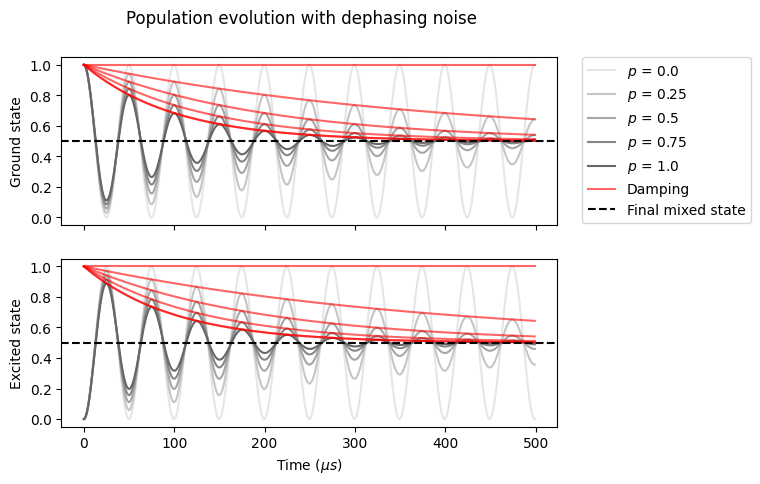

In [36]:
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "g": g_state,
    "r": r_state,
}

# We define the decay profile
def decay_profile(noise_prob, times):
    return 0.5 * (1 + np.exp(-0.5 * noise_prob * times))


# We plot the population evolution
fig, axs = plt.subplots(2)
fig.suptitle("Population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="Ground state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="Excited state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["g"],
    dephasing_results,
    noise_probabilities,
    decay_profile,
    axs[0],
    1 / 2,
    True,
)
plot_basis_population(
    basis["r"],
    dephasing_results,
    noise_probabilities,
    decay_profile,
    axs[1],
    1 / 2,
)

This plot shows the results of hamiltonian evolution(rabi oscillations) plus the effects of the dephasing channel on the excited state and ground state population. When we increase the probability of the noisy channel acting, the rabi oscillations are increasingly damped.

The dephasing channel destroys off-diagonal elements of the density matrix, and tends towards a stationary state with zero off-diagonals. Here, due to the Rabi oscillations, the stationary value is the maximally mixed state.

In other words the system converges to the density matrix $\rho = \frac{1}{2} \mathbb I = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$.

Notice that the ground state and excited state populations are $\frac{T}{2}$ out of phase.

In [37]:
# Final state
dephasing_results[-1].states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49679069+0.j         0.        +0.00083748j]
 [0.        -0.00083748j 0.50320931+0.j        ]]

#### Depolarizing Channel

In the following we illustrate the results of the single qubit depolarizing channel.

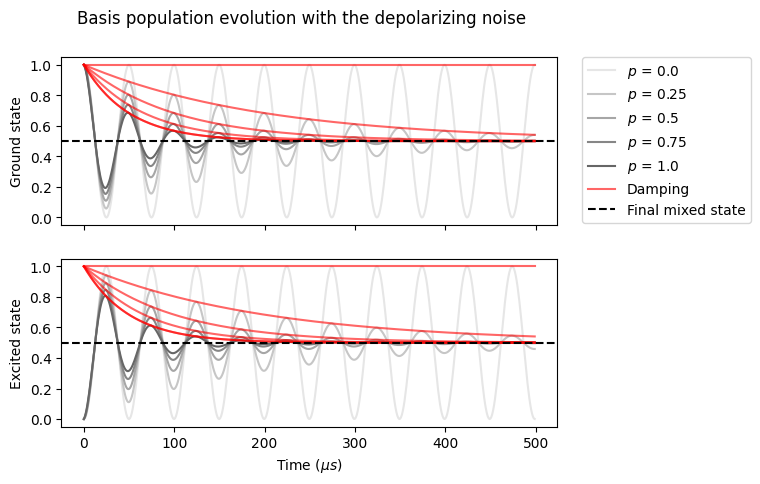

In [38]:
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "g": g_state,
    "r": r_state,
}

# We define the decay profile
def decay_profile(noise_prob, times):
    return 0.5 * np.exp(-noise_prob * times) + 0.5


fig, axs = plt.subplots(2)
fig.suptitle("Basis population evolution with the depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="Ground state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="Excited state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["g"],
    depolarizing_results,
    noise_probabilities,
    decay_profile,
    axs[0],
    1 / 2,
    True,
)
plot_basis_population(
    basis["r"],
    depolarizing_results,
    noise_probabilities,
    decay_profile,
    axs[1],
    1 / 2,
)

The depolarising channel is a severely pessimistic channel and has the maximally mixed state as its stationary value.

To have a better view of the impact of the depolarizing channel, we will use the bloch sphere representation of the density matrix.

### bloch sphere Representation

Any density matrix of a mixed state may be written as follows: $\rho = \frac{\mathbb{I} + \vec{r}.\vec{\sigma}}{2} $

$\vec{r} $ is the vector representing the mixed state in the bloch sphere.

In [39]:
def vector_to_dm(r_x, r_y, r_z):
    """
    Transform a vector in the bloch sphere into a density matrix
    """

    return 0.5 * (
        qutip.qeye(2)
        + r_x * qutip.sigmax()
        + r_y * qutip.sigmay()
        + r_z * qutip.sigmaz()
    )


def dm_to_vector(rho):
    """
    From a mixed state rho returns the corresponding vector in the bloch sphere
    """

    I = 2 * rho - np.eye(2)
    r_x = np.real((I[0, 1] + I[1, 0]) / 2)
    r_y = np.real((I[1, 0] - I[0, 1]) / 2)
    r_z = np.real(I[0, 0])

    return r_x, r_y, r_z


def depolarizing_channel(rho, prob):
    """
    Depolarizing channel Kraus representation
    """
    return (1 - 3 * prob / 4) * rho + prob / 4 * (
        qutip.sigmax() * rho * qutip.sigmax()
        + qutip.sigmay() * rho * qutip.sigmay()
        + qutip.sigmaz() * rho * qutip.sigmaz()
    )

Let's choose few points in the bloch sphere

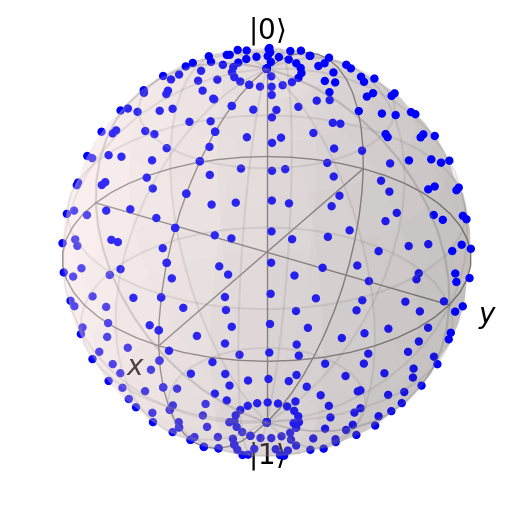

In [45]:
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
r = 1
n = len(u)
# x, y, z coordinates with fixed radius r from center X0, Y0, Z0

x = r * np.reshape(np.outer(np.cos(u), np.sin(v)), newshape=(n**2, 1))
y = r * np.reshape(np.outer(np.sin(u), np.sin(v)), newshape=(n**2, 1))
z = r * np.reshape(
    np.outer(np.ones(np.size(u)), np.cos(v)), newshape=(n**2, 1)
)

# Then we build the bloch with the above points
b = qutip.Bloch()
points = [x, y, z]
b.add_points(points)
b.show()

Now, let's observe the effect of the depolarizing channel on the bloch sphere

For every point of the bloch sphere, we find its corresponding density matrix. Afterwards we apply the depolarizing channel. And with the output density matrix, we find its representation in the bloch sphere.

In [46]:
depolarizing_prob = 0.5
x_dp = x
y_dp = y
z_dp = z
n, p = x.shape
for i in range(n):
    for j in range(p):
        dm = vector_to_dm(x[i, j], y[i, j], z[i, j])
        dm_n = depolarizing_channel(dm, depolarizing_prob)
        r_x, r_y, r_z = dm_to_vector(dm_n)
        x_dp[i, j] = r_x
        y_dp[i, j] = r_y
        z_dp[i, j] = r_z

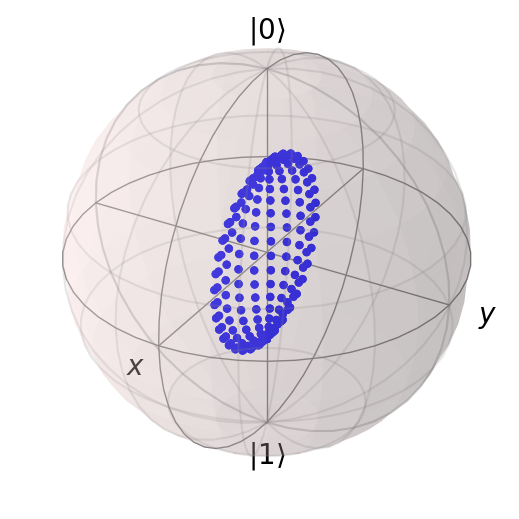

In [47]:
b = qutip.Bloch()
points = [x_dp, y_dp, z_dp]
b.add_points(points)
b.show()

The depolarizing channel contracts the bloch sphere across all directions. We can think of an inflation to revert the depolarizing effect on the bloch sphere, however, inflation is not a superoperator since it's not positive.

## 2-qubit noisy simulations

We already know what happens in a single qubit configuration. But we would like to study the multi-qubit case. To do so we start with two qubits.

We will analyze two configurations. One with near atoms and another with distant atoms and see how effective noise channels interact with the system.

The concept of far or near is defined by the rydberg radius. Two qubits are near when there are not distant more than the rydberg radius and far otherwise.

In [50]:
# Rydberg blockade radius
omega = 2 * np.pi
r_interatomic = Chadoq2.rydberg_blockade_radius(omega)
print(f"Rydberg radius ({r_interatomic}) > 5 ")

Rydberg radius (9.756753962298905) > 5 


### Near atoms

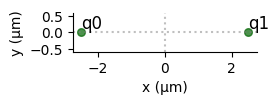

In [51]:
# We choose two qubits distant with each other less than the rydberg blochade
reg = Register.from_coordinates([(0, 0), (5, 0)], prefix="q")

reg.draw()

We will use the same pulse as before

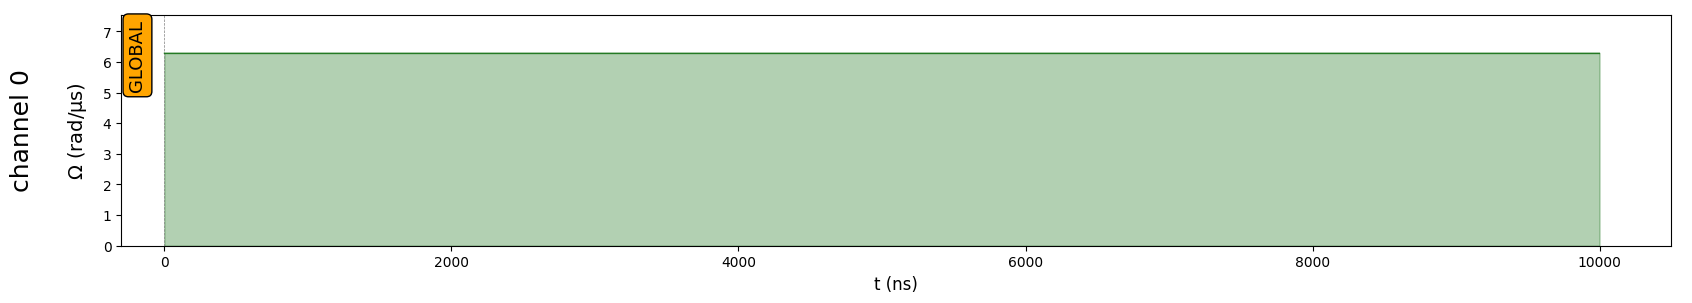

In [52]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, omega, 0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

In [53]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We made an approximation to be able to simulate Krauss channels in multi-qubit systems. We denoted it, the *uncorrelated noise approximation*. It relies on the fact that the probability of two qubits to undergo an effective noise are independent i.e:$\\$
$Pr(q_i = Nq_i, q_j= Nq_j) = Pr(q_i = Nq_i) Pr(q_j = Nq_j)$, $\forall i \neq j$ where $N$ is a noise operator.

Let's take $p = Pr(q_i = Nq_i), \forall i$, and $m$ the number of qubit noised, the underlying probability is $p^m$. Therefore, if $p\ll 1$ we get: $p^m \longrightarrow 0$

So the more likely states are: $Nq_j\otimes_{i\neq j}q_i$ , all equiprobable.

When an effective noise probability is higher than $0.2$, we get a warning telling you are out of the *uncorrelated noise approximation*

In [ ]:
config = SimConfig(noise="dephasing", dephasing_prob=0.5)
clean_simu.add_config(config)

/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


#### Noisy simulations

In [54]:
clean_simu.reset_config()

noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.25


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.25 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  0.5


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))
/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))
/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  0.75


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))
/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  1.0


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


#### Dephasing Channel

In the following we illustrate the results of the two qubit dephasing channel.

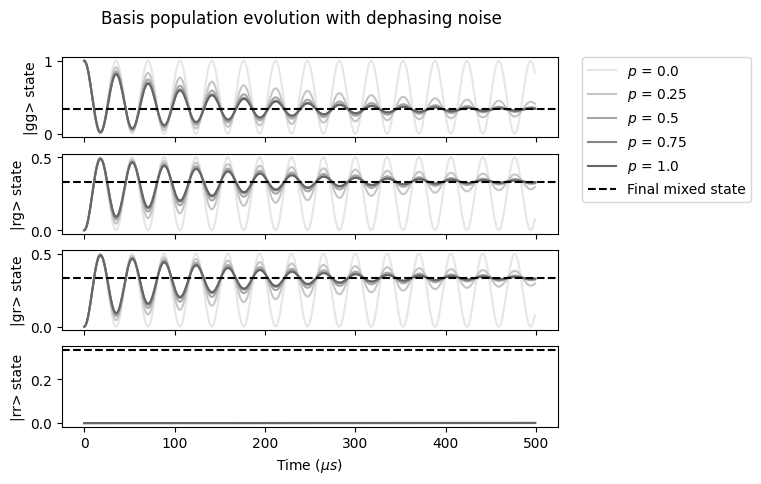

In [55]:
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "gg": qutip.tensor(g_state, g_state),
    "rg": qutip.tensor(r_state, g_state),
    "gr": qutip.tensor(g_state, r_state),
    "rr": qutip.tensor(r_state, r_state),
}
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    dephasing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 3,
    True,
)
plot_basis_population(
    basis["rg"], dephasing_results, noise_probabilities, None, axs[1], 1 / 3
)
plot_basis_population(
    basis["gr"], dephasing_results, noise_probabilities, None, axs[2], 1 / 3
)
plot_basis_population(
    basis["rr"], dephasing_results, noise_probabilities, None, axs[3], 1 / 3
)

Normally, $p>0.2$ is out of our approximation. But in order to see clearly where the population converges, we plotted some samples for $p>0.2$.

We can easily notice that: $\braket{gg|\rho(t)|gg}, \braket{gr|\rho(t)|gr}$ and $\braket{rg|\rho(t)|rg}  $ converges to $\frac{1}{3} $ when $\braket{rg|\rho(t)|rg}  $ stays at zero.

Atom 2 is inside the Rydberg radius, so the all excited state is prevented. We can conclude that the dephasing channel "respects the blockade effect".

The final mixed states is then: 

$\rho = \frac{1}{3} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} ) $

Let's see whether it's the same with the depolarizing channel or not.

#### Depolarizing Channel

In the following we illustrate the results of the single qubit depolarizing channel.

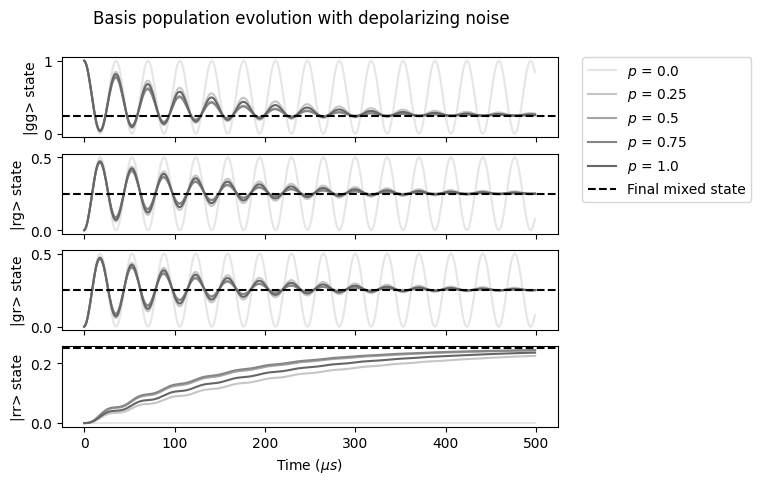

In [56]:
# Basis population with depolarizing noise
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "gg": qutip.tensor(g_state, g_state),
    "rg": qutip.tensor(r_state, g_state),
    "gr": qutip.tensor(g_state, r_state),
    "rr": qutip.tensor(r_state, r_state),
}
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    depolarizing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 4,
    True,
)
plot_basis_population(
    basis["rg"], depolarizing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], depolarizing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], depolarizing_results, noise_probabilities, None, axs[3], 1 / 4
)

Because of the Rydberg blockade, the state $\ket{rr} $ state is supposed to be unreachable. As we observe in the $\ket{rr} $ state population with $p=0 $ (the hazy brown bottom line).

But, after exposing the system to the depolarizing noise the blockade is broken and the output mixed state is:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

This is a distinctive difference from the dephasing channel we were not able to observe with one qubit: _The depolarizing channel breaks the Rydberg blockade_

Let's look at the case of distant qubits

### Distant qubtits

In [57]:
reg = Register.from_coordinates([(0, 0), (20, 0)], prefix="q")

print(f"20 = R > Ryderg radius = {r_interatomic} ")
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "channel 0")

20 = R > Ryderg radius = 9.756753962298905 


So there is no blockade

### Noisy simulations

In [58]:
clean_simu.reset_config()

noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.25
Noise probability =  0.5
Noise probability =  0.75
Noise probability =  1.0


#### Dephasing Channel

In the following we illustrate the results of the two qubits dephasing channel.

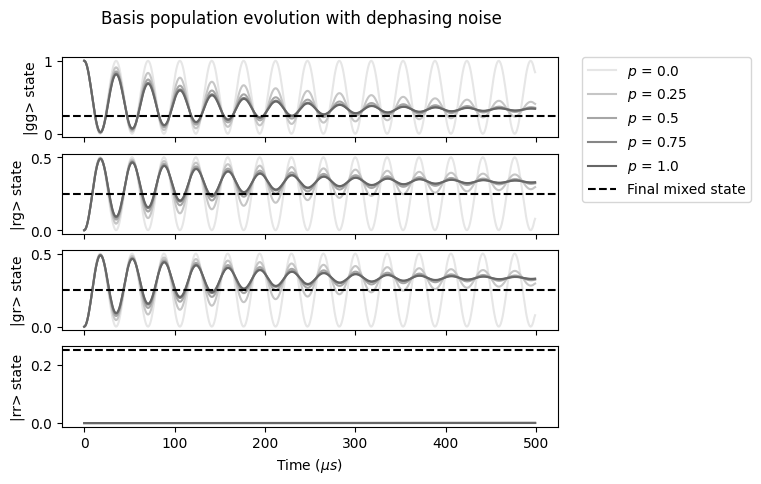

In [59]:
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "gg": qutip.tensor(g_state, g_state),
    "rg": qutip.tensor(r_state, g_state),
    "gr": qutip.tensor(g_state, r_state),
    "rr": qutip.tensor(r_state, r_state),
}
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    dephasing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 4,
    True,
)
plot_basis_population(
    basis["rg"], dephasing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], dephasing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], dephasing_results, noise_probabilities, None, axs[3], 1 / 4
)

We obtain a non-zero population in the $\ket{rr} $ state as expected since atom 2 is outside the blockade radius. The output mixed state we obtain is:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

#### Depolarizing Channel

In the following we illustrate the results of the two qubits depolarizing channel.

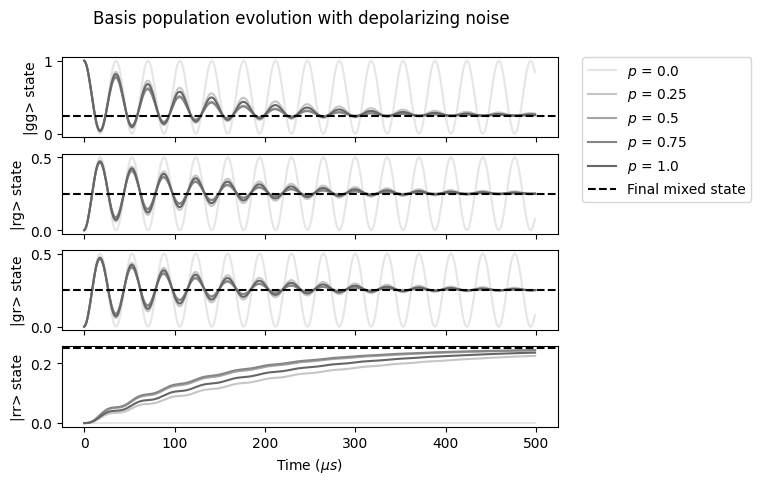

In [60]:
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "gg": qutip.tensor(g_state, g_state),
    "rg": qutip.tensor(r_state, g_state),
    "gr": qutip.tensor(g_state, r_state),
    "rr": qutip.tensor(r_state, r_state),
}
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    depolarizing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 4,
    True,
)
plot_basis_population(
    basis["rg"], depolarizing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], depolarizing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], depolarizing_results, noise_probabilities, None, axs[3], 1 / 4
)

We can't expect more than the dephasing channel in this case since there is no Blockade effect. The output mixed state remains:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

While driving atoms from $\ket{g} $ to $\ket{r} $, with a resonant pulse($\delta $ = 0), the noise channels acts accordingly:

* For near atoms there is a Rydberg blockade: the dephasing channel respects the blockade so the output density matrix is $\rho = \frac{1}{3} (\ket{gg} + \ket{gr} + \ket{rg}) $. Whereas, the depolarizing channel breaks the blockade and makes available the all-excited state so leads to a final state $\rho = \frac{1}{4} (\ket{gg} + \ket{gr} + \ket{rg} + \ket{rr})$

* With distant atoms the blockade is broken: the system undergoing either the depolarizing channel or the dephasing channel, can reach the all-excited state $\ket{rr} $ leading the output mixed state to $\rho = \frac{1}{4} (\ket{gg} + \ket{gr} + \ket{rg} + \ket{rr})$